<a href="https://colab.research.google.com/github/AmbiTyga/73String/blob/main/Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!pip install scrapy -q
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from time import time
import argparse
from w3lib.html import remove_tags
import requests
from scrapy.selector import Selector
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

In [20]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2021-02-14 19:22:41--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-02-14 19:22:41--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-02-14 19:22:41--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [21]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [24]:
del STOPWORDS,argparse,glove,oov,t,vocab

# Preprocessing

In [5]:

import json, operator
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
  else:
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
      
  return embeddings_index
  
def build_vocab(texts):
  '''
  Creates a vocabulary from the given corpus
  texts -> pandas Series object
  build_vocab(...) -> Dict()
  '''
  sentences = texts.str.split().values
  vocab = {}
  for sentence in sentences:
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1
  return vocab

# Checks how many words present in embeddings wrt dataset
def check_coverage(vocab, embeddings_index):
  '''
  Checks the vocabulary from the given corpus with GLoVE data
  Returns out of vocabulary words from corpus that are not present in GLoVE data
  '''
  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
      try:
          known_words[word] = embeddings_index[word]
          nb_known_words += vocab[word]
      except:
          unknown_words[word] = vocab[word]
          nb_unknown_words += vocab[word]
          pass

  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
  unknown_words = pd.DataFrame(unknown_words,columns=['Word','Count'])
  return unknown_words

In [23]:
# t = pd.read_csv('train.csv')
glove = load_embed('/content/glove.840B.300d.txt')
# vocab = build_vocab(t['Short Description'])
oov = check_coverage(vocab,glove)

In [22]:
# t = pd.read_csv('train.csv')
glove = load_embed('/content/glove.840B.300d.txt')
# vocab = build_vocab(t['Short Description'])
oov = check_coverage(vocab,glove)

Found embeddings for 99.997% of vocab
Found embeddings for  98.430% of all text


In [6]:
def clean(sentence):
  '''
  Removes unnecessary characters from the string
  And replaces the acronyms from business terms
  sentence -> str
  clean(...) -> str
  '''
  sentence = re.sub(r"\bcorp\b\.?",'corporation',sentence,flags = re.I)
  sentence = re.sub(r"\bInc\b\.?",'incorporation',sentence,flags = re.I)
  sentence = re.sub(r"\bco\b\.?",'company',sentence,flags = re.I)
  sentence = re.sub(r"\bs\.?p\.?a\b\.?",'sales and purchase agreement',sentence,flags = re.I)
  sentence = re.sub(r"\bASA\b\.?",'Advertising and Selling Association',sentence,flags = re.I)
  sentence = re.sub(r"\bSA\b\.?",'corporation',sentence,flags = re.I)
  sentence = re.sub(r"\bPLC\b\.?",'Public Limited Company',sentence,flags = re.I)
  sentence = re.sub(r"\bAB\b\.?",'Aktiebolag',sentence,flags = re.I)
  sentence = re.sub(r"\bAG\b\.?",'Aktiengesellschaft',sentence,flags = re.I)
  sentence = re.sub(r"\be-",'electronic ',sentence,flags = re.I)
  
  
  sentence = re.sub(r'(â€™s)',"'",sentence,flags = re.I)
  sentence = re.sub(r'Â',"",sentence,flags = re.I)
  sentence = re.sub(r'\%'," percent",sentence,flags = re.I)
  sentence = re.sub(r'\#',"Number ",sentence,flags = re.I)
  sentence = re.sub(r'(a-zA-Z0-9)?(\.)(a-zA-Z0-9)?',' ',sentence,flags = re.I)
  sentence = re.sub(r'\b(\w+)( \1\b)+',r'\1', sentence)
  
  
  sentence = re.sub(r'-'," ",sentence,flags = re.I)
  sentence = re.sub(r'[,!?\'\:\(\)\/;]','',sentence)
  sentence = re.sub(r'\s+'," ",sentence)

  return sentence

  

def inc_info(keywords):
  '''
  The function googles the keywords, and returns the details from Knowledge Graph panel of Google. 
  '''
  keywords = keywords.replace(" ",'+')
  url = f'https://www.google.com/search?&q={keywords}'

  req = requests.get(url,
                   headers= {'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'})
  details_with_tags = Selector(text = req.text).css('span.hgKElc').get()

  if not details_with_tags:
    details_with_tags = Selector(text = req.text).css('div.kno-rdesc span').get()

  if details_with_tags:
    details = remove_tags(details_with_tags)
    return details

def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
  else:
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
      
  return embeddings_index

def change_term(df):
  name,description = df['Company Name'], df['Short Description']
  desc = []
  for i,j in zip(name,description):
    if i.lower() in j.lower():
      j = re.sub(r'\b{name}\b'.format(name = i),'Company',j,flags = re.I)
      desc.append(j)
    else:
      desc.append(j)
  return desc

In [7]:
glove = load_embed("/content/glove.840B.300d.txt")

In [14]:
test.head()

,Company,Business Description
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...
2,Force Motors Ltd,Force Motors Limited is a holding company. The...
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...


In [30]:
train = pd.read_excel("/content/Training_Data.01 (1).xlsx")
test = pd.read_excel("/content/Testing_Data_2_ (1).xlsx")
train.drop_duplicates('Business Description',inplace=True,ignore_index=True)
train['Business Description'].fillna(train[train['Business Description'].isna()]['Company Name'].apply(inc_info),inplace = True)
train.dropna(inplace = True)

train['Short Description'] = train['Business Description'].apply(clean)
train['Company Name'] = train['Company Name'].apply(clean)

test['Short Description'] = test['Business Description'].apply(clean)
test['Company Name'] = test['Company '].apply(clean)

In [31]:
data = test.copy()

data['Short Description'] = data['Short Description'].apply(lambda x: ' '.join([item for item in x.split() if item not in STOPWORDS]))
data['Short Description'] = change_term(data)

In [24]:
data['Short Description'] = data['Short Description'].apply(lambda x: ' '.join(["UnkW" if item not in glove else item for item in x.split()]))
data['Short Description'] = data['Short Description'].str.replace(r'\b(\w+)( \1\b)+',r'\1')
data['Short Description'] = data['Short Description'].str.replace(r'\bUnkW\b','<OOV>')

In [245]:
data.head(10)

,Company Name,Business Description,Industry Classification Tag,Short Description
0,ADSOUTH PARTNERS incorporation,"Adsouth Partners, Inc. provides advertising ag...",Advertising,Company provides advertising agency services s...
1,Artec Global Media incorporation,"Artec Global Media, Inc., formerly Artec Consu...",Advertising,Company formerly Artec Consulting corporation ...
2,Betawave corporation,Betawave Corporation provides online marketing...,Advertising,Company provides online marketing solutions We...
3,BOSTON OMAHA corporation,Boston Omaha Corporation is engaged in the bus...,Advertising,Company engaged business various sectors inclu...
4,Bright Mountain Media incorporation,"Bright Mountain Media, Inc. is a digital media...",Advertising,Company digital media holding company online p...
5,Cardlytics incorporation,"Cardlytics, Inc. is engaged in developing a pu...",Advertising,Company engaged developing purchase intelligen...
6,CMG HOLDINGS GROUP incorporation,"CMG Holdings Group, Inc. is a holding company....",Advertising,Company holding company The Company sports ent...
7,COMSCORE incorporation,"comScore, Inc. is a cross-platform measurement...",Advertising,Company cross platform measurement company The...
8,Connected Media Technologies incorporation,"Connected Media Technologies, Inc. is a sales ...",Advertising,Company sales marketing company focused digita...
9,CREDIT ONE FINANCIAL incorporation,"Credit One Financial, Inc., through its subsid...",Advertising,Company subsidiary CEM International Ltd opera...


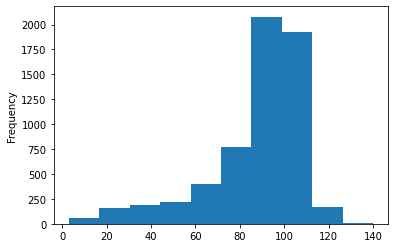

In [246]:
data['short_words_count'] = data['Short Description'].str.split().apply(lambda x:len(x))
data['short_words_count'].plot.hist()

In [256]:
data.query('short_words_count>124')

,Company Name,Business Description,Industry Classification Tag,Short Description,short_words_count
523,TMM incorporation,"TMM, Inc., a technology company, develops and ...",Application Software,Company technology company develops distribute...,140
705,ABEONA THERAPEUTICS incorporation,Abeona Therapeutics Inc. is a clinical-stage b...,Biotechnology,Company clinical stage biopharmaceutical compa...,128
1951,SavWatt USA incorporation,"SavWatt USA, Inc. (SavWatt) is engaged in deve...",Electrical Components & Equipment,Company SavWatt engaged developing light emitt...,137
2297,Iamgold corporation,Iamgold Corp is a Canada-based gold mining com...,Gold,Company Canada based gold mining company The C...,125
2344,Maverix Metals incorporation,"Maverix Metals Inc, formerly MacMillan Mineral...",Gold,Company formerly MacMillan Minerals incorporat...,131
3533,Jupiter Marine International HoldingsInc,"Jupiter Marine International Holdings, Inc. is...",Leisure Products,Jupiter Marine International Holdings incorpor...,133
3536,Mattel incorporation,"Mattel, Inc. manufactures and markets a range ...",Leisure Products,Company manufactures markets range toy product...,128
4044,Pacific Ethanol incorporation,"Pacific Ethanol, Inc. ist ein Produzent und Ve...",Oil & Gas Refining & Marketing,Company ist ein Produzent und <OOV> von <OOV> ...,130
4165,Hot Mamas Foods incorporation,Hot Mamas Foods Inc. is engaged in the busines...,Packaged Foods & Meats,Company engaged business manufacturing gourmet...,129


In [13]:
t = pd.read_csv('train.csv')

In [14]:
t.head()

,Industry Classification Tag,Short Description
0,Advertising,Company provides advertising agency services s...
1,Advertising,Company formerly Artec Consulting corporation ...
2,Advertising,Company provides online marketing solutions We...
3,Advertising,Company engaged business various sectors inclu...
4,Advertising,Company digital media holding company online p...


# Building Vocab and embeddings

In [34]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [35]:
del data
data = pd.concat([train['Short Description'],
                  test['Short Description']],ignore_index = True)

In [40]:
glove['A']

array([-2.0996e-01, -1.5577e-01, -3.7736e-01,  2.2892e-01, -1.4712e-01,
       -4.1782e-01, -1.9491e-01,  6.1021e-02,  5.7944e-02,  7.9813e-01,
       -4.9189e-01,  2.6116e-02,  1.6173e-01,  2.8898e-01, -2.6319e-03,
       -1.8420e-01, -8.7295e-02,  1.8144e+00, -1.4008e-01,  2.3612e-01,
       -7.5722e-03, -4.4965e-01, -8.9656e-02,  2.7359e-01,  2.0097e-01,
       -7.2507e-03,  8.5632e-02, -2.5656e-02,  7.4721e-02, -4.6209e-01,
       -7.2882e-02, -1.6263e-01,  4.3647e-01, -2.2789e-01,  6.8795e-01,
        5.2565e-02,  6.9874e-01, -2.6120e-01, -2.0619e-01, -5.6306e-01,
        6.7343e-01,  7.3758e-01,  5.6451e-01, -6.2426e-02,  1.7391e-01,
       -4.3643e-01, -2.8697e-01, -4.3337e-01, -4.9453e-03,  1.5617e-01,
       -3.4879e-01,  3.7111e-01,  1.1258e-01,  2.5172e-01, -3.1563e-02,
        3.0049e-01,  4.4813e-01, -1.5333e-02,  1.6217e-01, -4.8068e-01,
        7.2301e-02,  6.1309e-01,  3.4949e-01,  2.1502e-01, -7.2819e-02,
       -2.1604e-01, -7.5218e-03,  2.7666e-01, -6.7807e-02,  8.04

In [43]:
vocab = build_vocab(data)
embeddings = dict()
glove['<OOV>'] = np.random.rand(300)
for i in vocab:
  embeddings[i] = glove[i]

In [44]:
len(),len(glove)

(39066, 2196017)

# Model

In [45]:
class GloveTokenizer:
    def __init__(self, vectors, unk='<OOV>', pad='<pad>'):
        # self.vectors = vectors
        self.unk = unk
        self.pad = pad
        self.stoi = dict()
        self.itos = dict()
        self.embedding_matrix = list()
        # with open(filename, 'r', encoding='utf8') as f: # Read tokenizer file
        for i, embed in enumerate(vectors):
            # values = line.split(" ")
            self.stoi[embed] = i
            self.itos[i] = embed
            self.embedding_matrix.append(vectors[embed])
        if self.unk is not None: # Add unk token into the tokenizer
            i += 1
            self.stoi[self.unk] = i
            self.itos[i] = self.unk
            self.embedding_matrix.append(np.random.rand(len(self.embedding_matrix[0])))
        if self.pad is not None: # Add pad token into the tokenizer
            i += 1
            self.stoi[self.pad] = i
            self.itos[i] = self.pad
            self.embedding_matrix.append(np.zeros(len(self.embedding_matrix[0])))
        self.embedding_matrix = np.array(self.embedding_matrix).astype(np.float32) # Convert if from double to float for efficiency

    def encode(self, sentence):
        if type(sentence) == str:
            sentence = sentence.split(' ')
        elif len(sentence): # Convertible to list
            sentence = list(sentence)
        else:
            raise TypeError('sentence should be either a str or a list of str!')
        encoded_sentence = []
        for word in sentence:
            encoded_sentence.append(self.stoi.get(word, self.stoi[self.unk]))
        return encoded_sentence

    def decode(self, encoded_sentence):
        try:
            encoded_sentence = list(encoded_sentence)
        except Exception as e:
            print(e)
            raise TypeError('encoded_sentence should be either a str or a data type that is convertible to list type!')
        sentence = []
        for encoded_word in encoded_sentence:
            sentence.append(self.itos[encoded_word])
        return sentence

    def embedding(self, encoded_sentence):
        return self.embedding_matrix[np.array(encoded_sentence)]

In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Industry Classification Tag'].values)
le.transform(['Trading Companies & Distributors'])


array([61])

In [92]:
train.to_numpy()

array([['Advertising',
        'Company provides advertising agency services specializing direct response media campaigns It also owns distribution rights number products acquired The business consists two operating sectors advertising products During year ended December 31 2005 internally developed marketed two lines flashlights branded Extreme Beam Flashlight Clip Light The Company obtained exclusive five year marketing distribution rights Hercules Hook distribution rights D Shed PEARL Anti Wrinkle Moisturizing Mist 2005 In 2005 Company also organized Genco Power Solutions incorporation Genco purpose marketing selling installing servicing integrated power generator systems residential homeowners commercial business throughout Florida The Company owns 66 percent Genco'],
       ['Advertising',
        'Company formerly Artec Consulting corporation marketing firm The Company provides online marketing reporting solutions including lead generation performance media affiliate marketing re

In [101]:
from sklearn.preprocessing import LabelEncoder

class TextLevelGNNDataset(Dataset): # For instantiating train, validation and test dataset
    def __init__(self, node_sets, neighbor_sets, public_edge_mask, labels):
        super(TextLevelGNNDataset).__init__()
        self.node_sets = node_sets
        self.neighbor_sets = neighbor_sets
        self.public_edge_mask = public_edge_mask
        self.labels = labels

    def __getitem__(self, i):
        return torch.LongTensor(self.node_sets[i]), \
               torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1), \
               self.public_edge_mask[torch.LongTensor(self.node_sets[i]).unsqueeze(-1).repeat(1, torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1).shape[-1]), torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1)], \
               torch.LongTensor(self.labels[i])

    def __len__(self):
        return len(self.labels)


class TextLevelGNNDatasetClass: # This class is used to achieve parameters sharing among datasets
    def __init__(self, train_filename, tokenizer, MAX_LENGTH=10, p=2, min_freq=2, train_validation_split=0.8):
        self.train_filename = train_filename
        # self.test_filename = test_filename
        self.tokenizer = tokenizer
        self.MAX_LENGTH = MAX_LENGTH
        self.p = p
        self.min_freq = min_freq
        self.train_validation_split = train_validation_split
        self.le = LabelEncoder()
        # self.train_data = pd.read_csv(self.train_filename, header=None)
        # self.test_data = pd.read_csv(self.test_filename, header=None)
        
        self.train_data = pd.read_csv(self.train_filename)


        self.stoi = {'<OOV>': 0, '<pad>': 1} # Re-index
        self.itos = {0: '<OOV>', 1: '<pad>'} # Re-index
        self.vocab_count = len(self.stoi)
        self.embedding_matrix = None
        self.le.fit(self.train_data['Industry Classification Tag'].values)
        # self.label_dict = dict(zip(self.train_data['Industry Classification Tag'].unique(), pd.get_dummies(self.train_data['Industry Classification Tag'].unique()).values.tolist())) # make changes her

        self.train_dataset, self.validation_dataset = random_split(self.train_data.to_numpy(), [int(len(self.train_data) * train_validation_split), len(self.train_data) - int(len(self.train_data) * train_validation_split)])
        # self.test_dataset = self.test_data.to_numpy()

        self.build_vocab() # Based on train_dataset only. Updates self.stoi, self.itos, self.vocab_count and self.embedding_matrix

        # self.train_dataset, self.validation_dataset, self.test_dataset, self.edge_stat, self.public_edge_mask = self.prepare_dataset()
        self.train_dataset, self.validation_dataset, self.edge_stat, self.public_edge_mask = self.prepare_dataset()

    def build_vocab(self):
        vocab_list = [sentence.split(' ') for _, sentence in self.train_dataset]
        unique_vocab = []
        for vocab in vocab_list:
            unique_vocab.extend(vocab)
        unique_vocab = list(set(unique_vocab))
        for vocab in unique_vocab:
            if vocab in self.tokenizer.stoi.keys():
                self.stoi[vocab] = self.vocab_count
                self.itos[self.vocab_count] = vocab
                self.vocab_count += 1
        self.embedding_matrix = self.tokenizer.embedding(self.tokenizer.encode(list(self.stoi.keys())))

    def prepare_dataset(self): # will also build self.edge_stat and self.public_edge_mask
        # preparing self.train_dataset
        node_sets = [[self.stoi.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.train_dataset] # Only retrieve the first MAX_LENGTH words in each document
        neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        labels = [self.le.transform([label])[0] for label,_ in self.train_dataset]
        print('At TextLevelGNN Class')
        print(labels)
        # Construct edge statistics and public edge mask
        edge_stat, public_edge_mask = self.build_public_edge_mask(node_sets, neighbor_sets, min_freq=self.min_freq)
        
        train_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)

        # preparing self.validation_dataset
        node_sets = [[self.stoi.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.validation_dataset] # Only retrieve the first MAX_LENGTH words in each document
        neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        labels = [self.le.transform([label])[0] for label,_ in self.validation_dataset]
        validation_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)
        print(labels)
        print(500*'-')
        # # preparing self.test_dataset
        # node_sets = [[self.stoi.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence, _ in self.test_dataset] # Only retrieve the first MAX_LENGTH words in each document
        # neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        # labels = [self.label_dict[label] for _,_,label in self.test_dataset]
        # test_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)

        # return train_dataset, validation_dataset, test_dataset, edge_stat, public_edge_mask
        return train_dataset, validation_dataset, edge_stat, public_edge_mask

    def build_public_edge_mask(self, node_sets, neighbor_sets, min_freq=2):
        edge_stat = torch.zeros(self.vocab_count, self.vocab_count)
        for node_set, neighbor_set in zip(node_sets, neighbor_sets):
            for neighbor in neighbor_set:
                for to_node in neighbor:
                    edge_stat[node_set, to_node] += 1
        public_edge_mask = edge_stat < min_freq # mark True at uncommon edges
        return edge_stat, public_edge_mask


def create_neighbor_set(node_set, p=2):
    if type(node_set[0]) != int:
        raise ValueError('node_set should be a 1D list!')
    if p < 0:
        raise ValueError('p should be an integer >= 0!')
    sequence_length = len(node_set)
    neighbor_set = []
    for i in range(sequence_length):
        neighbor = []
        for j in range(-p, p+1):
            if 0 <= i + j < sequence_length:
                neighbor.append(node_set[i+j])
        neighbor_set.append(neighbor)
    return neighbor_set

In [118]:
labels[0]

tensor([     3395342848, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139706696204288,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      1,               1,               1,               1,
            

In [96]:
torch.nn.utils.rnn.pad_sequence(torch.tensor([[10]]), batch_first=True, padding_value=1)

tensor([[10]])

In [106]:
def pad_custom_sequence(sequences):
    '''
    To pad different sequences into a padded tensor for training. The main purpose of this function is to separate different sequence, pad them in different ways and return padded sequences.
    Input:
        sequences <list>: A sequence with a length of 4, representing the node sets sequence in index 0, neighbor sets sequence in index 1, public edge mask sequence in index 2 and label sequence in index 3.
                          And the length of each sequences are same as the batch size.
                          sequences: [node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence, label_sequence]
    Return:
        node_sets_sequence <torch.LongTensor>: The padded node sets sequence (works with batch_size >= 1).
        neighbor_sets_sequence <torch.LongTensor>: The padded neighbor sets sequence (works with batch_size >= 1).
        public_edge_mask_sequence <torch.BoolTensor>: The padded public edge mask sequence (works with batch_size >= 1).
        label_sequence <torch.FloatTensor>: The padded label sequence (works with batch_size >= 1).
    '''
    node_sets_sequence = []
    neighbor_sets_sequence = []
    public_edge_mask_sequence = []
    label_sequence = []
    for node_sets, neighbor_sets, public_edge_mask, label in sequences:
        node_sets_sequence.append(node_sets)
        neighbor_sets_sequence.append(neighbor_sets)
        public_edge_mask_sequence.append(public_edge_mask)
        label_sequence.append(label)
    node_sets_sequence = torch.nn.utils.rnn.pad_sequence(node_sets_sequence, batch_first=True, padding_value=1)
    neighbor_sets_sequence, _ = padding_tensor(neighbor_sets_sequence)
    public_edge_mask_sequence, _ = padding_tensor(public_edge_mask_sequence)
    print("At pad custom sequence")
    print(label_sequence)
    label_sequence = torch.nn.utils.rnn.pad_sequence(label_sequence, batch_first=True, padding_value=1)
    
    print(label_sequence)
    return node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence, label_sequence


def padding_tensor(sequences, padding_idx=1):
    '''
    To pad tensor of different shape to be of the same shape, i.e. padding [tensor.rand(2, 3), tensor.rand(3, 5)] to a shape (2, 3, 5), where 0th dimension is batch_size, 1st and 2nd dimensions are padded.
    Input:
        sequences <list>: A list of tensors
        padding_idx <int>: The index that corresponds to the padding index
    Return:
        out_tensor <torch.tensor>: The padded tensor
        mask <torch.tensor>: A boolean torch tensor where 1 (represents '<pad>') are marked as true
    '''
    num = len(sequences)
    max_len_0 = max([s.shape[0] for s in sequences])
    max_len_1 = max([s.shape[1] for s in sequences])
    out_dims = (num, max_len_0, max_len_1)
    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_idx)
    for i, tensor in enumerate(sequences):
        len_0 = tensor.size(0)
        len_1 = tensor.size(1)
        out_tensor[i, :len_0, :len_1] = tensor
    mask = out_tensor == padding_idx # Marking all places with padding_idx as mask
    return out_tensor, mask

In [103]:

class MessagePassing(nn.Module):
    def __init__(self, vertice_count, input_size, out_size, dropout_rate=0, padding_idx=1):
        super(MessagePassing, self).__init__()
        self.vertice_count = vertice_count # |V|
        self.input_size = input_size # d
        self.out_size = out_size # c
        self.dropout_rate = dropout_rate
        self.padding_idx = padding_idx
        self.information_rate = nn.Parameter(torch.rand(self.vertice_count, 1)) # (|V|, 1), which means it is a column vector
        self.linear = nn.Linear(self.input_size, self.out_size) # (d, c)
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, node_sets, embedded_node, edge_weight, embedded_neighbor_node):
        # node_sets: (batch_size, l)
        # embedded_node: (batch_size, l, d)
        # edge_weight: (batch_size, max_sentence_length, max_neighbor_count)
        # embedded_neighbor_node: (batch_size, max_sentence_length, max_neighbor_count, d)

        tmp_tensor = (edge_weight.view(-1, 1) * embedded_neighbor_node.view(-1, self.input_size)).view(embedded_neighbor_node.shape) # (batch_size, max_sentence_length, max_neighbor_count, d)
        tmp_tensor = tmp_tensor.masked_fill(tmp_tensor == 0, -1e18) # (batch_size, max_sentence_length, max_neighbor_count, d), mask for M such that masked places are marked as -1e18
        tmp_tensor = self.dropout(tmp_tensor)
        M = tmp_tensor.max(dim=2)[0] # (batch_size, max_sentence_length, d), which is same shape as embedded_node (batch_size, l, d)
        information_rate = self.information_rate[node_sets] # (batch_size, l, 1)
        information_rate = information_rate.masked_fill((node_sets == self.padding_idx).unsqueeze(-1), 1) # (batch_size, l, 1), Fill the information rate of the padding index as 1, such that new e_n = (1-i_r) * M + i_r * e_n = (1-1) * 0 + 1 * e_n = e_n (no update)
        embedded_node = (1 - information_rate) * M + information_rate * embedded_node # (batch_size, l, d)
        sum_embedded_node = embedded_node.sum(dim=1) # (batch_size, d)
        x = F.relu(self.linear(sum_embedded_node)) # (batch_size, c)
#         x = self.dropout(x) # if putting dropout with p=0.5 here, it is equivalent to wiping 4 choices out of 8 choices on the question sheet, which does not make sense. If a dropout layer is placed at here, it works the best when p=0 (disabled), followed by p=0.05, ..., p=0.5 (worst and does not even converge).
        y = F.softmax(x, dim=1) # (batch_size, c) along the c dimension
        return y


class TextLevelGNN(nn.Module):
    def __init__(self, pretrained_embeddings, out_size=8, dropout_rate=0, padding_idx=1):
        super(TextLevelGNN, self).__init__()
        self.out_size = out_size # c
        self.padding_idx = padding_idx
        self.weight_matrix = nn.Parameter(torch.randn(pretrained_embeddings.shape[0], pretrained_embeddings.shape[0])) # (|V|, |V|)        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=self.padding_idx) # (|V|, d)
        self.message_passing = MessagePassing(vertice_count=pretrained_embeddings.shape[0], input_size=pretrained_embeddings.shape[1], out_size=self.out_size, dropout_rate=dropout_rate, padding_idx=self.padding_idx) # input_size: (d,); out_size: (c,)
        self.public_edge_weight = nn.Parameter(torch.randn(1, 1)) # (1, 1)

    def forward(self, node_sets, neighbor_sets, public_edge_mask):
        # node_sets: (batch_size, l)
        # neighbor_sets: (batch_size, max_sentence_length, max_neighbor_count)
        # neighbor_sets_mask: (batch_size, max_sentence_length, max_neighbor_count) (no need)
        # public_edge_mask: (batch_size, max_sentence_length, max_neighbor_count)

        embedded_node = self.embedding(node_sets) # (batch_size, l, d)
        edge_weight = model.weight_matrix[node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]), neighbor_sets] # (batch_size, max_sentence_length, max_neighbor_count), neighbor_sets.shape[-1]: eg p=2, this expression=5; p=3, this expression=7. This is to first make node_sets to have same shape with neighbor_sets, then just do 1 query instead of 32*100 queries to speed up performance
        a = edge_weight * ~public_edge_mask # (batch_size, max_sentence_length, max_neighbor_count)
        b = self.public_edge_weight.unsqueeze(2).expand(1, public_edge_mask.shape[-2], public_edge_mask.shape[-1]) * public_edge_mask # (batch_size, max_sentence_length, max_neighbor_count)
        edge_weight = a + b # (batch_size, max_sentence_length, max_neighbor_count)
        embedded_neighbor_node = self.embedding(neighbor_sets) # (batch_size, max_sentece_length, max_neighbor_count, d)

        # Apply mask to edge_weight, to mask and cut-off any relationships to the padding nodes
        edge_weight = edge_weight.masked_fill((node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]) == self.padding_idx) | (neighbor_sets == self.padding_idx), 0) # (batch_size, max_sentence_length, max_neighbor_count)
        x = self.message_passing(node_sets, embedded_node, edge_weight, embedded_neighbor_node) # (batch_size, c)
        return x



In [87]:
tokenizer = GloveTokenizer(embeddings)

In [107]:
dataset = TextLevelGNNDatasetClass(train_filename='/content/train.csv',
                                   train_validation_split=0.9,
                                   tokenizer=tokenizer,
                                   MAX_LENGTH=124)
train_loader = DataLoader(dataset.train_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)
validation_loader = DataLoader(dataset.validation_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)

device = torch.device(f'cuda:0')
model = TextLevelGNN(pretrained_embeddings=torch.tensor(dataset.embedding_matrix), dropout_rate=0.45).to(device)
criterion = nn.CrossEntropyLoss()

At TextLevelGNN Class
[44, 40, 60, 26, 17, 4, 25, 7, 10, 36, 17, 47, 55, 2, 50, 47, 42, 58, 46, 21, 53, 50, 33, 50, 45, 38, 43, 7, 56, 47, 15, 59, 27, 48, 47, 33, 2, 35, 25, 49, 59, 4, 10, 26, 13, 9, 0, 50, 50, 18, 60, 47, 55, 42, 50, 32, 3, 49, 7, 44, 56, 35, 42, 60, 50, 7, 50, 48, 50, 50, 58, 4, 22, 32, 55, 8, 0, 39, 39, 50, 31, 22, 56, 47, 19, 32, 22, 25, 23, 7, 22, 60, 50, 21, 43, 34, 57, 50, 3, 22, 42, 9, 7, 20, 22, 37, 42, 41, 57, 53, 6, 9, 42, 58, 0, 7, 56, 8, 32, 50, 44, 47, 5, 19, 51, 18, 47, 28, 37, 52, 42, 13, 4, 39, 5, 57, 23, 42, 19, 9, 44, 50, 37, 50, 46, 42, 26, 34, 7, 17, 50, 6, 7, 33, 39, 41, 29, 21, 47, 47, 50, 50, 13, 10, 40, 8, 47, 13, 45, 55, 35, 17, 7, 21, 24, 24, 7, 44, 41, 42, 2, 33, 52, 50, 10, 50, 34, 8, 50, 51, 7, 50, 50, 51, 31, 7, 5, 23, 3, 34, 50, 47, 57, 61, 22, 32, 38, 33, 3, 50, 50, 18, 21, 58, 4, 22, 49, 7, 39, 37, 22, 12, 17, 36, 22, 48, 22, 13, 33, 14, 7, 7, 53, 43, 52, 53, 3, 5, 4, 21, 11, 42, 23, 14, 14, 5, 52, 39, 8, 4, 22, 26, 50, 40, 27, 17, 16,

In [116]:
len(labels[0])

60

In [108]:
lr = 1e-5
lr_decay_factor = 0.9
lr_decay_every = 5
weight_decay = 1e-4

warm_up_epoch = 0
early_stopping_patience = 10
early_stopping_criteria = 'loss'
best_epoch = 0 # Initialize

training = {}
validation = {}
testing = {}
training['accuracy'] = []
training['loss'] = []
validation['accuracy'] = []
validation['loss'] = []
testing['accuracy'] = []
testing['loss'] = []

for epoch in range(20):
    model.train()
    train_loss = 0
    train_correct_items = 0
    previous_epoch_timestamp = time()

    if epoch % lr_decay_every == 0: # Update optimizer for every lr_decay_every epochs
        if epoch != 0: # When it is the first epoch, disable the lr_decay_factor
            lr *= lr_decay_factor
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(train_loader):
#         print('Finished batch:', i)
        node_sets = node_sets.to(device)
        neighbor_sets = neighbor_sets.to(device)
        public_edge_masks = public_edge_masks.to(device)
        labels = labels.to(device)
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    train_accuracy = train_correct_items / len(dataset.train_dataset)

    model.eval()
    validation_loss = 0
    validation_correct_items = 0
    for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(validation_loader):
        node_sets = node_sets.to(device)
        neighbor_sets = neighbor_sets.to(device)
        public_edge_masks = public_edge_masks.to(device)
        labels = labels.to(device)
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        validation_loss += loss.item()
        validation_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    validation_accuracy = validation_correct_items / len(dataset.validation_dataset)

#     model.eval()
    # test_loss = 0
    # test_correct_items = 0
    # for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(test_loader):
    #     node_sets = node_sets.to(device)
    #     neighbor_sets = neighbor_sets.to(device)
    #     public_edge_masks = public_edge_masks.to(device)
    #     labels = labels.to(device)
    #     prediction = model(node_sets, neighbor_sets, public_edge_masks)
    #     loss = criterion(prediction, labels).to(device)
    #     test_loss += loss.item()
    #     test_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    # test_accuracy = test_correct_items / len(dataset.test_dataset)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Time Used: {time()-previous_epoch_timestamp:.2f}s')
    training['accuracy'].append(train_accuracy)
    training['loss'].append(train_loss)
    validation['accuracy'].append(validation_accuracy)
    validation['loss'].append(validation_loss)
    # testing['accuracy'].append(test_accuracy)
    # testing['loss'].append(test_loss)

    # add warmup mechanism for warm_up_epoch epochs
    if epoch >= warm_up_epoch:
        best_epoch = warm_up_epoch
        # early stopping
        if early_stopping_criteria == 'accuracy':
            if validation['accuracy'][epoch] > validation['accuracy'][best_epoch]:
                best_epoch = epoch
            elif epoch >= best_epoch + early_stopping_patience:
                print(f'Early stopping... (No further increase in validation accuracy) for consecutive {early_stopping_patience} epochs.')
                break
        if early_stopping_criteria == 'loss':
            if validation['loss'][epoch] < validation['loss'][best_epoch]:
                best_epoch = epoch
            elif epoch >= best_epoch + early_stopping_patience:
                print(f'Early stopping... (No further decrease in validation loss) for consecutive {early_stopping_patience} epochs.')
                break
    elif epoch + 1 == warm_up_epoch:
        print('--- Warm up finished ---')


At pad custom sequence
[tensor([     3395342848, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139706696204288,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992,
                      0, 139702401236992,               0, 139702401236992]), tensor([15046138432, 15080704512, 15080775168, 15080714240, 15

RuntimeError: ignored

In [100]:
labels[0]

tensor([ 15046138432, 137438953504, 137438953504, 137438953504, 433791697010,
        137438953588, 137438953533, 476741369972, 425201762418, 197568495720,
        287762808927, 408021893166, 472446402670, 472446402606, 463856468076,
        463856468063, 493921239151, 214748364915, 171798691940, 472446402665,
        502511173744, 188978561140, 498216206368, 489626271841, 433791696999,
        188978561140, 511101108256, 450971566181, 446676598887, 188978561140,
        408021893152, 433791696978, 502511173732, 498216206435, 476741369961,
        197568495726, 433791696999, 408021893236, 472446402661, 468151435381,
        489626271784, 429496729701, 425201762421, 450971566196, 472446402671,
        188978561065, 450971566112, 472446402663, 489626271855, 408021893221,
        472446402665, 433791696996, 176093659256,  14995387984,            1],
       device='cuda:0')

In [78]:
le.transform(le.classes_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])